In [1]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
from pandas.tseries.holiday import USFederalHolidayCalendar as uscal

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns

#import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance

import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR
%matplotlib inline

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [95]:
model_prepx = pd.read_csv('Mayfair_all.csv')

In [97]:
model_prepx['hour_before_usage'] = model_prepx['interval_kWh'].shift(1)
model_prep = model_prepx.dropna(subset=['hour_before_usage'])

In [98]:
training = model_prep[model_prep['timestamp'] < '2020-09-29 00:00:00']
testing = model_prep[model_prep['timestamp'] > '2020-10-12 00:00:00']

In [99]:
len(training), len(testing)

(3383, 5326)

### Linear Regressor 

In [100]:
# Modeling - baseline
y = training['interval_kWh']
X = training[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes', 'hour']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr_mod = lr.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(1.4386779506856853, 1.4745013494554395)

### RFC Regressor

In [101]:
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.3642083657863613, 1.0221076690307331)

### XG-Boost Regressor

In [102]:
regressor = xgboost.XGBRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


(0.4275854342125701, 1.0453378683680903)

### Support Vector Regressor

In [103]:
regressor = SVR()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(1.726120341111933, 1.7705567035785557)

### Extra Tree Regressor

In [104]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.00038344501381887573, 1.0681737494089834)

### Bagging Regressor

In [105]:
regressor = BaggingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.3947582183681515, 1.0554078486997638)

### Gradient Boosting Regressor

In [106]:
regressor = GradientBoostingRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.8893725188654332, 1.0401699930703907)

## Further tuning & Additional Variables
**Testing models:**
- RFC
- Extra Tree

**Additional Features:**
- Season
- Temperature from the hour before
- Working day vs non-working day

### Feature Selection

In [151]:
y = model_prep['interval_kWh']
X = model_prep[['temp', 'pressure', 'humidity', 'hour_before_usage',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.25, random_state=123)

In [152]:
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores

,0,0
0,temp,21.839841
1,pressure,15.341667
2,humidity,7.130236
3,hour_before_usage,344.664988
4,sunlight_No,8.323869
5,sunlight_Yes,8.323869
6,hour,15.109329
7,hour_before,28.383332
8,workday_0,1.172858
9,workday_1,1.172858


## Train test modeling - Pre-retrofit Non-shuffle modeling
In pre-retrofit data, the first 75% will be used in training and 25% for testing (not shuffled)

### Feature Importance

In [153]:
training = model_prep[model_prep['timestamp'] < '2020-09-29 00:00:00']
testing = model_prep[model_prep['timestamp'] > '2020-10-12 00:00:00']

y = model_prep['interval_kWh']
X = model_prep[['temp', 'pressure', 'humidity', 'hour_before_usage',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.25, random_state=123)

In [154]:
best_features_t = SelectKBest(score_func=f_classif, k='all')
fit_t = best_features_t.fit(X_test,y_test)
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X_train,y_train)
df_scores = pd.DataFrame(fit_t.scores_)
df_score = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat({'Feature':df_columns,
                            'test': df_scores, 'train': df_score},axis=1)
feature_scores

,Feature,test,train
,0,0,0
0,temp,6.991240,18.137652
1,pressure,5.847459,12.009569
2,humidity,2.950824,5.846740
3,hour_before_usage,104.444173,280.073879
4,sunlight_No,3.155741,6.898429
5,sunlight_Yes,3.155741,6.898429
6,hour,4.560416,12.785556
7,hour_before,9.041005,23.430281
8,workday_0,0.949515,1.182298


### RFC 

In [155]:
# More features for RFC
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.2929195057641147, 0.8135105886524825)

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


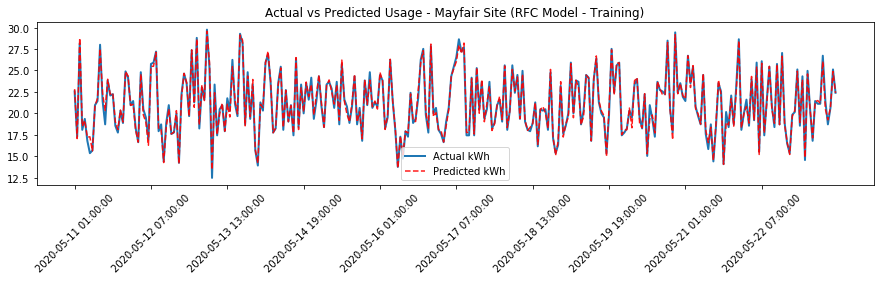

In [156]:
# Sample visualization for RFC results on training dataset
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][0:300], y_train[0:300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][0:300], y_predt[0:300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][0:300:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (RFC Model - Training)')
plt.legend()

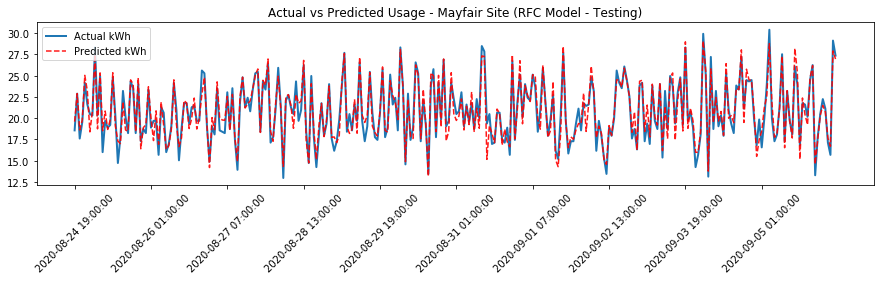

In [157]:
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][2538:2838], y_test[0:300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][2538:2838], y_pred[0:300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][2538:2838:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (RFC Model - Testing)')
plt.legend()

### Extra Trees

In [158]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(4.256577027504209e-06, 0.7926309645390069)

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


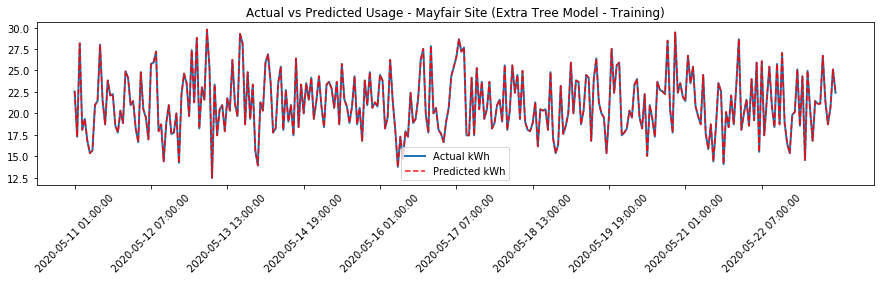

In [159]:
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][0:300], y_train[0:300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][0:300], y_predt[0:300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][0:300:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (Extra Tree Model - Training)')
plt.legend()

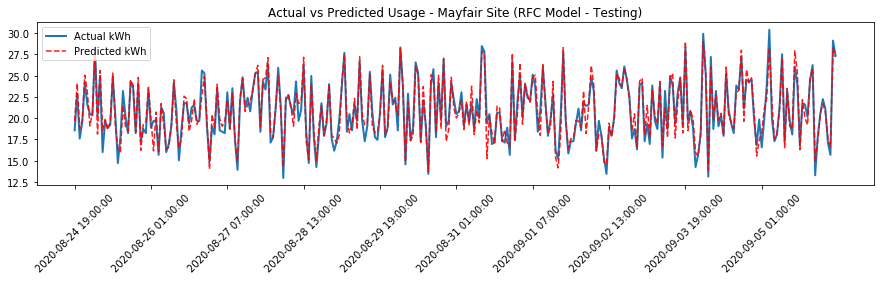

In [160]:
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][2538:2838], y_test[0:300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][2538:2838], y_pred[0:300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][2538:2838:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (RFC Model - Testing)')
plt.legend()

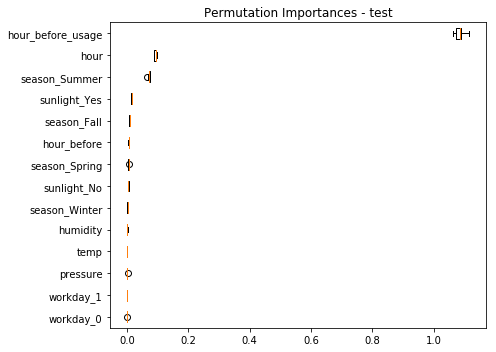

In [161]:
result = permutation_importance(lr_mod, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 5))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances - test")
fig.tight_layout()

## Train test modeling - Pre-retrofit shuffle modeling
In pre-retrofit data, shuffle data then having 75% for training and 25% for testing

In [163]:
training = model_prep[model_prep['timestamp'] < '2020-09-29 00:00:00']
testing = model_prep[model_prep['timestamp'] > '2020-10-12 00:00:00']

y = training['interval_kWh']
X = training[['temp', 'pressure', 'humidity', 'hour_before_usage',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [164]:
best_features_t = SelectKBest(score_func=f_classif, k='all')
fit_t = best_features_t.fit(X_test,y_test)
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X_train,y_train)
df_scores = pd.DataFrame(fit_t.scores_)
df_score = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat({'Feature':df_columns,
                            'test': df_scores, 'train': df_score},axis=1)
feature_scores

C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [11] are constant.
  UserWarning)
C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [11] are constant.
  UserWarning)
C:\Users\szhang\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Feature,test,train
,0,0,0
0,temp,3.520238,6.049984
1,pressure,2.633031,2.051379
2,humidity,4.238317,8.086878
3,hour_before_usage,28.926617,73.479861
4,sunlight_No,4.360997,8.877575
5,sunlight_Yes,4.360997,8.877575
6,hour,5.491512,14.240341
7,hour_before,3.846238,6.536591
8,workday_0,0.974683,1.104473


### RFC

In [165]:
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(0.2585385005912491, 0.711012047281324)

In [166]:
rfc_train = pd.DataFrame({'y': y_train, 'y_p': y_predt}).reset_index()
rfc_test = pd.DataFrame({'y': y_test, 'y_p': y_pred}).reset_index()

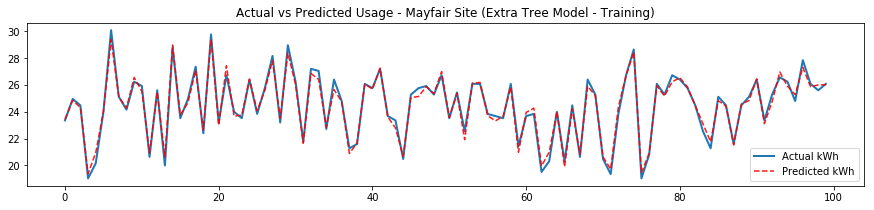

In [167]:
plt.figure(figsize=(15,3))
plt.plot(rfc_train['y'][:100], linewidth = 2, label = 'Actual kWh')
plt.plot(rfc_train['y_p'][:100], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
#plt.xticks(training['timestamp'][0:300:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (Extra Tree Model - Training)')
plt.legend()

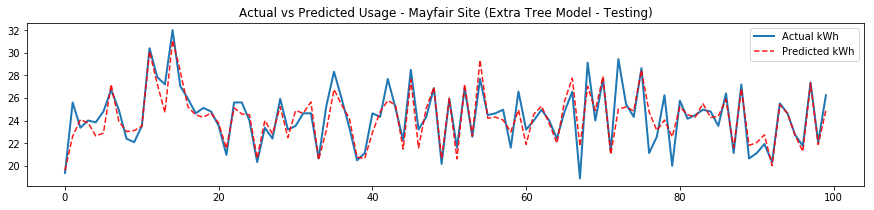

In [168]:
plt.figure(figsize=(15,3))
plt.plot(rfc_test['y'][:100], linewidth = 2, label = 'Actual kWh')
plt.plot(rfc_test['y_p'][:100], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
#plt.xticks(training['timestamp'][0:300:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (Extra Tree Model - Testing)')
plt.legend()

### Extra Tree

In [169]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred = lr_mod.predict(X_test)
y_predt = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt),mean_absolute_error(y_test, y_pred)

(4.1623965337201584e-05, 0.7121364349881799)

In [170]:
et_train = pd.DataFrame({'y': y_train, 'y_p': y_predt}).reset_index()
et_test = pd.DataFrame({'y': y_test, 'y_p': y_pred}).reset_index()

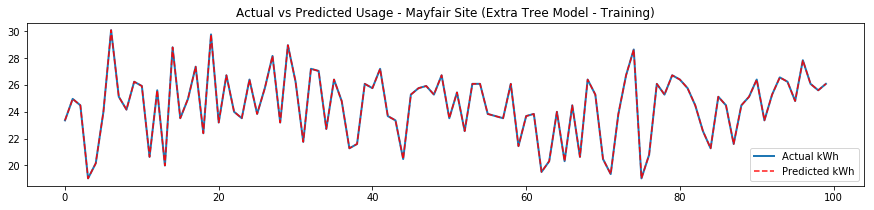

In [171]:
plt.figure(figsize=(15,3))
plt.plot(et_train['y'][:100], linewidth = 2, label = 'Actual kWh')
plt.plot(et_train['y_p'][:100], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
#plt.xticks(training['timestamp'][0:300:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (Extra Tree Model - Training)')
plt.legend()

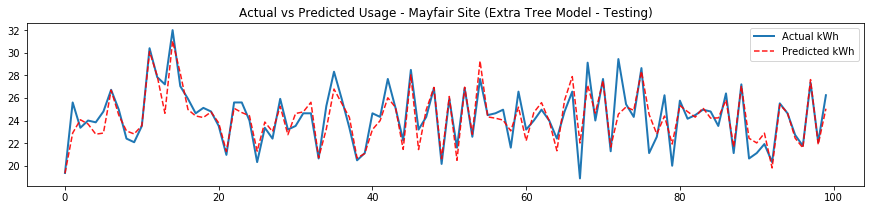

In [172]:
plt.figure(figsize=(15,3))
plt.plot(et_test['y'][:100], linewidth = 2, label = 'Actual kWh')
plt.plot(et_test['y_p'][:100], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
#plt.xticks(training['timestamp'][0:300:30], rotation = 45)
plt.title('Actual vs Predicted Usage - Mayfair Site (Extra Tree Model - Testing)')
plt.legend()

## Full Dataset Pre-retrofit Training & Post-retrofit Prediction

In [177]:
y_train = training['interval_kWh']
X_train = training[['temp', 'pressure', 'humidity', 'hour_before_usage',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]
y_test= testing['interval_kWh']
X_test = testing[['temp', 'pressure', 'humidity', 'hour_before_usage',
                'sunlight_No', 'sunlight_Yes', 'hour', 'hour_before', 'workday_0', "workday_1",
               'season_Fall', 'season_Winter', 'season_Spring', 'season_Summer']]

### RFC

In [178]:
regressor = RandomForestRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_rfc = lr_mod.predict(X_test)
y_predt_rfc = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_rfc)

0.2585385941472064

In [179]:
training['pred_usage'] = y_predt_rfc
testing['pred_usage'] = y_pred_rfc

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


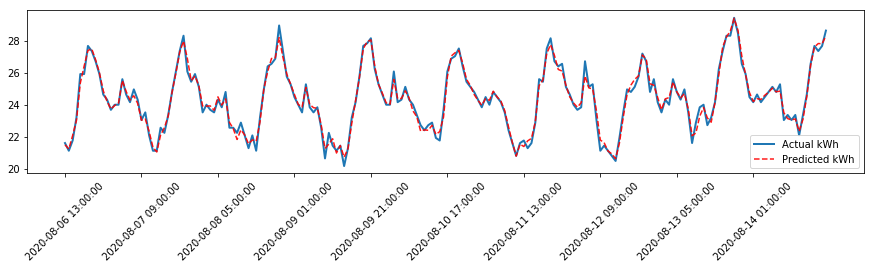

In [180]:
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][2100:2300], training['interval_kWh'][2100:2300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][2100:2300], training['pred_usage'][2100:2300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][2100:2300:20], rotation = 45)
plt.legend()

### Extra Tree

In [181]:
regressor = ExtraTreesRegressor()
lr_mod = regressor.fit(X_train, y_train)
y_pred_et = lr_mod.predict(X_test)
y_predt_et = lr_mod.predict(X_train)
mean_absolute_error(y_train, y_predt_et)

5.1078924055949666e-05

In [182]:
training['pred_usage_et'] = y_predt_et
testing['pred_usage_et'] = y_pred_et

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


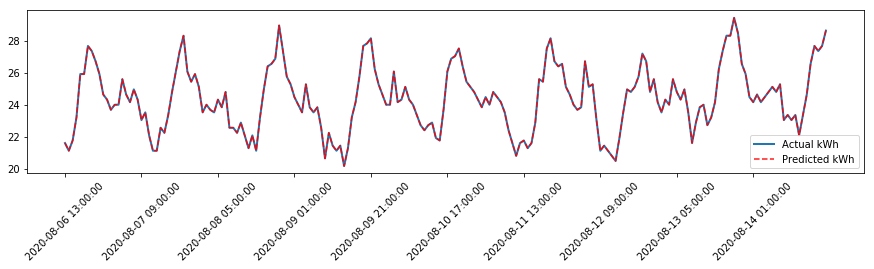

In [183]:
plt.figure(figsize=(15,3))
plt.plot(training['timestamp'][2100:2300], training['interval_kWh'][2100:2300], linewidth = 2, label = 'Actual kWh')
plt.plot(training['timestamp'][2100:2300], training['pred_usage_et'][2100:2300], alpha=0.9, color = 'r', linestyle = '--', label = 'Predicted kWh')
plt.xticks(training['timestamp'][2100:2300:20], rotation = 45)
plt.legend()

### Overall:
- Extra Tree performs slightly better on testing set but with a bit of overfitting issues
- Extra Tree is performing close to perfect for training set

## Saving calculation using extra trees

In [184]:
bills = pd.read_csv('Mayfair Court Bills.csv')
bills.columns

Index(['meter_uid', 'utility', 'utility_service_id', 'utility_billing_account',
       'utility_service_address', 'utility_meter_number',
       'utility_tariff_name', 'bill_start_date', 'bill_end_date', 'bill_days',
       'bill_statement_date', 'bill_total_kWh', 'bill_total', 'source',
       'updated', 'bill_volume', 'bill_total_unit',
       'Winter Usage On Peak_cost', 'Winter Usage On Peak_kwh',
       'Winter Usage Super Off Peak_cost', 'Winter Usage Super Off Peak_kwh',
       'Winter Usage Off Peak_cost', 'Winter Usage Off Peak_kwh',
       'Demand_cost', 'Demand_kw', 'pge_details_baseline_territory',
       'pge_details_net_generation', 'pge_details_serial',
       'pge_details_consumption', 'pge_details_rotating_outage_block',
       'Winter Usage Part Peak_cost', 'Winter Usage Part Peak_kwh',
       'supplier_1_total_cost', 'supplier_1_service_id', 'supplier_1_tariff',
       'supplier_1_total_volume', 'supplier_1_name', 'supplier_1_type',
       'supplier_1_total_unit', 'S

In [185]:
bill = bills[['bill_start_date', 'bill_end_date', 'bill_days',
       'bill_total_kWh', 'bill_total', 'bill_volume',  'Demand_cost', 'Demand_kw']]

In [186]:
bill

,bill_start_date,bill_end_date,bill_days,bill_total_kWh,bill_total,bill_volume,Demand_cost,Demand_kw
0,03/23/2021,04/22/2021,30,12824.32,2031.69,12824.32,430.44,30.08
1,02/22/2021,03/23/2021,29,12674.32,2790.83,12674.32,439.95,30.08
2,01/21/2021,02/22/2021,32,14109.36,2944.02,14109.36,394.79,29.44
3,12/21/2020,01/21/2021,31,14531.52,2892.81,14531.52,407.95,30.72
4,11/19/2020,12/21/2020,32,15069.92,2721.12,15069.92,399.60,30.72
5,10/21/2020,11/19/2020,29,13762.48,2795.77,13762.48,489.18,30.72
6,09/21/2020,10/21/2020,30,15623.04,3680.66,15623.04,708.40,35.20
7,08/20/2020,09/21/2020,32,19798.48,4631.19,19798.48,758.25,34.56
8,07/21/2020,08/20/2020,30,17573.28,4238.56,17573.28,758.25,34.56
9,06/22/2020,07/21/2020,29,16467.04,4001.29,16467.04,744.20,33.92


In [187]:
bill['s_timestamp'] = pd.to_datetime(bill['bill_start_date'])
bill['e_timestamp'] = pd.to_datetime(bill['bill_end_date'])

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [188]:
testing['timestamp'] = pd.to_datetime(testing['timestamp'])
training['timestamp'] = pd.to_datetime(training['timestamp'])

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [189]:
bill['pred_usage'] = 0
for i in range(len(bill)):
    if i < 6:
        bill['pred_usage'][i] = sum(testing[(testing['timestamp'] >= bill['s_timestamp'][i]) & (testing['timestamp'] < bill['e_timestamp'][i])]['pred_usage_et'])
        
    else:
        bill['pred_usage'][i] = sum(training[(training['timestamp'] >= bill['s_timestamp'][i]) & (training['timestamp'] < bill['e_timestamp'][i])]['pred_usage_et'])

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

In [190]:
bill

,bill_start_date,bill_end_date,bill_days,bill_total_kWh,bill_total,bill_volume,Demand_cost,Demand_kw,s_timestamp,e_timestamp,pred_usage
0,03/23/2021,04/22/2021,30,12824.32,2031.69,12824.32,430.44,30.08,2021-03-23,2021-04-22,15525
1,02/22/2021,03/23/2021,29,12674.32,2790.83,12674.32,439.95,30.08,2021-02-22,2021-03-23,15052
2,01/21/2021,02/22/2021,32,14109.36,2944.02,14109.36,394.79,29.44,2021-01-21,2021-02-22,16256
3,12/21/2020,01/21/2021,31,14531.52,2892.81,14531.52,407.95,30.72,2020-12-21,2021-01-21,16421
4,11/19/2020,12/21/2020,32,15069.92,2721.12,15069.92,399.60,30.72,2020-11-19,2020-12-21,17134
5,10/21/2020,11/19/2020,29,13762.48,2795.77,13762.48,489.18,30.72,2020-10-21,2020-11-19,15704
6,09/21/2020,10/21/2020,30,15623.04,3680.66,15623.04,708.40,35.20,2020-09-21,2020-10-21,4887
7,08/20/2020,09/21/2020,32,19798.48,4631.19,19798.48,758.25,34.56,2020-08-20,2020-09-21,19798
8,07/21/2020,08/20/2020,30,17573.28,4238.56,17573.28,758.25,34.56,2020-07-21,2020-08-20,17573
9,06/22/2020,07/21/2020,29,16467.04,4001.29,16467.04,744.20,33.92,2020-06-22,2020-07-21,16467


# Lav's to-do
- Baseline model
- 25% testing vs 75% training - Y
- Lav to do: actual vs prediction graphs to demonstrate model accuracy
- Lav to do: saving visualization